In [1]:
from pyspark.sql.types import (
    StructType, 
    LongType, 
    StringType, 
    StructField,
    DoubleType
)
from pyspark.sql.functions import (
    regexp_extract,
    date_format,
    from_unixtime,
    substring_index,
    col,
    lit,
    input_file_name,
    concat,
    year,
    month,
    weekofyear,
    lpad,
    countDistinct,
    when,
    min as _min,
    max as _max,
    mean,
    sum as _sum,
)
from pyspark import StorageLevel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import ipywidgets as widgets

# Set up the parameters

In [2]:
start_date = datetime(2020,1,1)
end_date = datetime(2020, 3,1)
#How may bins should we have between 0 and 1 (see this as 1/bin_size)
nbins_0_1 = 1/20

In [3]:
def _get_candidate_files(start_date, end_date, spark, base="/project/monitoring/archive/condor/raw/metric/"):
    """
    Returns a list of hdfs folders that can contain data for the given dates.
    """
    st_date = start_date - timedelta(days=1)
    ed_date = end_date + timedelta(days=1)
    days = (ed_date - st_date).days
    pre_candidate_files = [
        "{base}/{day}{{,.tmp}}".format(
            base=base, day=(st_date + timedelta(days=i)).strftime("%Y/%m/%d")
        )
        for i in range(0, days)
    ]
    sc = spark.sparkContext
    # The candidate files are the folders to the specific dates,
    # but if we are looking at recent days the compaction procedure could
    # have not run yet so we will considerate also the .tmp folders.
    candidate_files = [
        "/project/monitoring/archive/condor/raw/metric/{}{{,.tmp}}".format(
            (st_date + timedelta(days=i)).strftime("%Y/%m/%d")
        )
        for i in range(0, days)
    ]
    FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
    URI = sc._gateway.jvm.java.net.URI
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
    fs = FileSystem.get(URI("hdfs:///"), sc._jsc.hadoopConfiguration())
    candidate_files = [url for url in candidate_files if fs.globStatus(Path(url))]
    return candidate_files

def generate_histogram(pd_data, bin_field, max_value=4, stacked=True):
    """
    Generate a plot based on the data provided. This method expects
    a pandas dataframe (pd_data) with a field defining the bins (bin_field)
    and the Type and count fields. 
    It will generate an stacked bar plot 
    """
    cms_types = pd_data.Type.unique()
    trimed = pd_data[np.logical_or(pd_data[bin_field].isnull(), pd_data[bin_field] < max_value) ].copy()
    trimed[bin_field] =  trimed[bin_field].astype(float).round(1).astype(str).str.zfill(int(np.log10(max_value))+3)
    grouped=pd_data[pd_data[bin_field]>max_value].groupby("Type").sum().reset_index()
    grouped[bin_field] = f"{max_value}+"
    full = pd.concat([trimed, grouped], sort=True)
    pivoted = full.pivot(index=bin_field, columns="Type", values="count")
    colors = sns.color_palette("hls", len(cms_types))
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(40, 7))
    pivoted.plot.bar(stacked=stacked, color=colors, ax=ax)
    return fig


In [4]:
schema = StructType([
    StructField('data', StructType([
        StructField("GlobalJobId", StringType(), nullable=False),
        StructField("Workflow", StringType(), nullable=False),
        StructField("RecordTime", LongType(), nullable=False),
        StructField("JobFailed", LongType(), nullable=False),
        StructField("Status", StringType(), nullable=True),
        StructField("Site", StringType(), nullable=True),
        StructField("Type", StringType(), nullable=True),
        StructField("WallClockHr", DoubleType(), nullable=False),
        StructField("CpuTimeHr", DoubleType(), nullable=True),
        StructField("RequestCpus", DoubleType(), nullable=True),
        StructField("CpuEff", DoubleType(), nullable=True),
    ])),
])

In [5]:
spark.catalog.clearCache()
folder = "/project/monitoring/archive/condor/raw/metric/"
raw_df = (spark.read.option("basePath",folder).json(_get_candidate_files(start_date, end_date, spark, base=folder),schema=schema)
          .select("data.*")
          .filter(f"""Status='Completed'
          AND JobFailed=0
          AND RecordTime >= {start_date.timestamp()*1000}
          AND RecordTime < {end_date.timestamp()*1000}
          """)
          .drop_duplicates(['GlobalJobId'])
        )

In [6]:
#raw_df.head()

In [7]:
raw_df = (raw_df.withColumn("RequestCpus",
                            when(col("RequestCpus").isNotNull(),
                                 col("RequestCpus"))
                            .otherwise(lit(1)))
          .withColumn("CoreTime", col("WallClockHr")*col("RequestCpus"))
         )

# Plots

In [8]:
grouped_wf = (raw_df.groupby("Workflow", "Type")
                    .agg(mean("CpuEff").alias("mean_cpueff"), 
                         (100*_sum("CpuTimeHr")/_sum("CoreTime")).alias("wf_cpueff"),
                         _sum("RequestCpus").alias("wf_cpus"),
                         _sum("CpuTimeHr").alias("wf_cputimehr"),
                         _sum("WallClockHr").alias("wf_wallclockhr")
                        )
                    .cache()
             )


In [9]:
filtered = grouped_wf.selectExpr("Workflow", "Type", "mean_cpueff", "wf_cpueff", f"floor(mean_cpueff * {nbins_0_1})/{nbins_0_1} as binsEff1", f"floor(wf_cpueff * {nbins_0_1})/{nbins_0_1} as binsEff2")

In [10]:
pd_Eff1 = filtered.groupby("Type", "binsEff1").count().toPandas()
pd_Eff2 = filtered.groupby("Type", "binsEff2").count().toPandas()

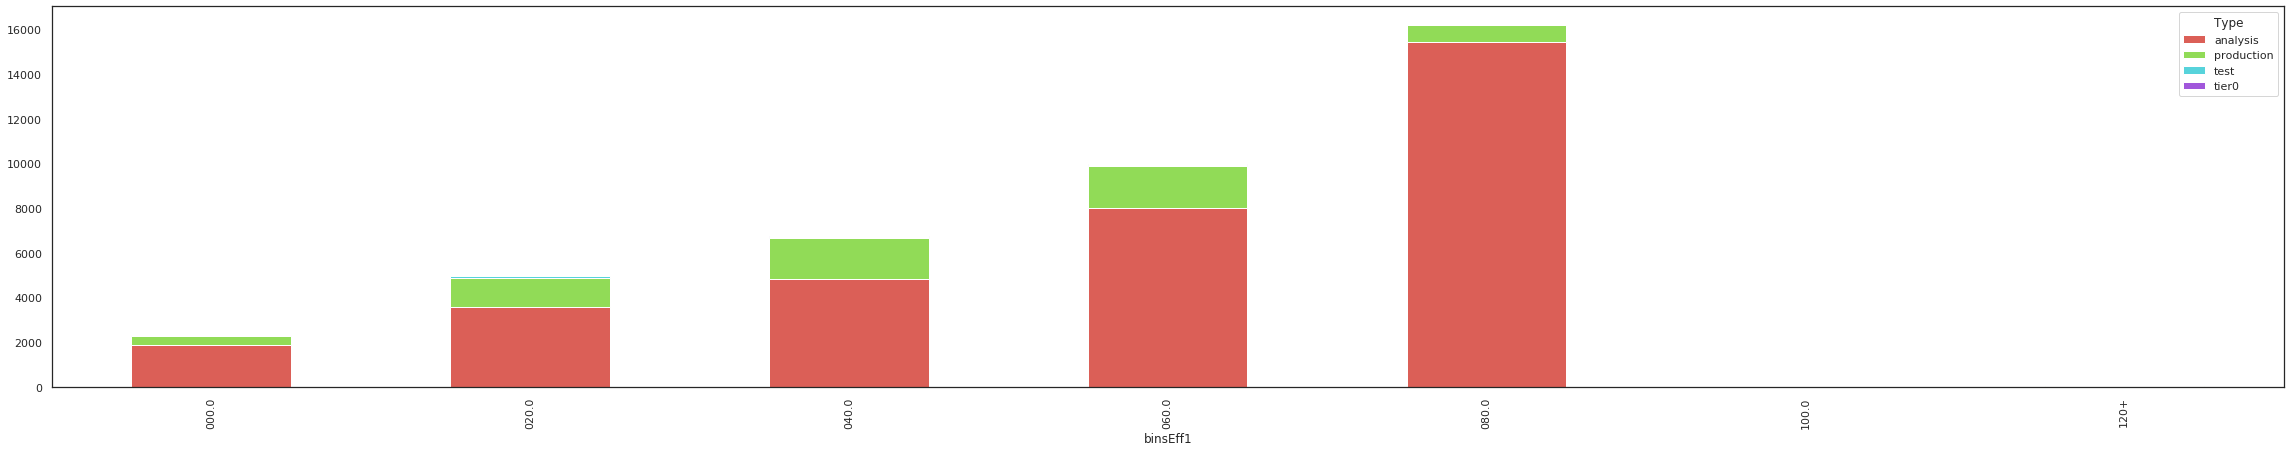

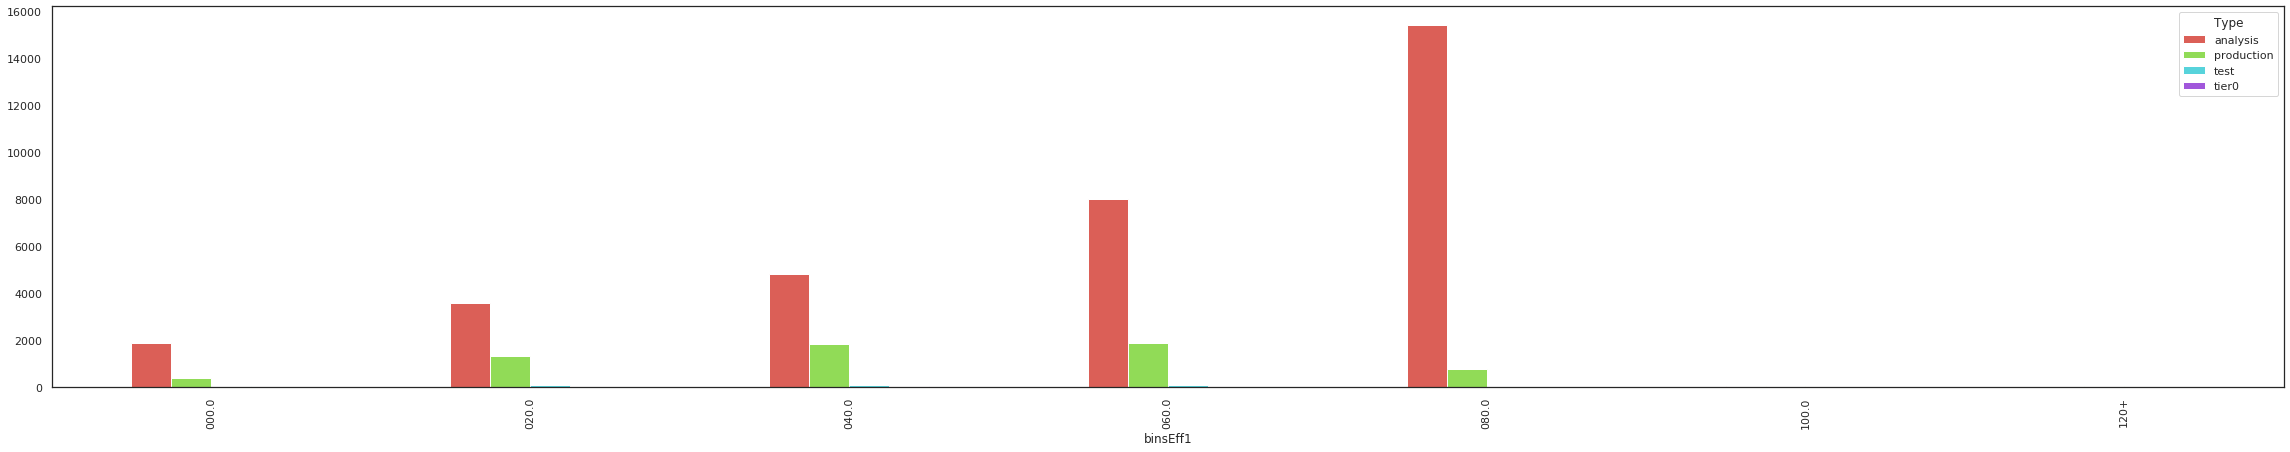

In [11]:
histo_eff1 = generate_histogram(pd_Eff1, "binsEff1", max_value=120)
histo_eff1_ns = generate_histogram(pd_Eff1, "binsEff1", max_value=120, stacked=False)
histo_eff1.savefig(f"binsEff1_{start_date.strftime('%Y%m%d')}-{end_date.strftime('%Y%m%d')}.png")
histo_eff1_ns.savefig(f"binsEff1-ns_{start_date.strftime('%Y%m%d')}-{end_date.strftime('%Y%m%d')}.png")

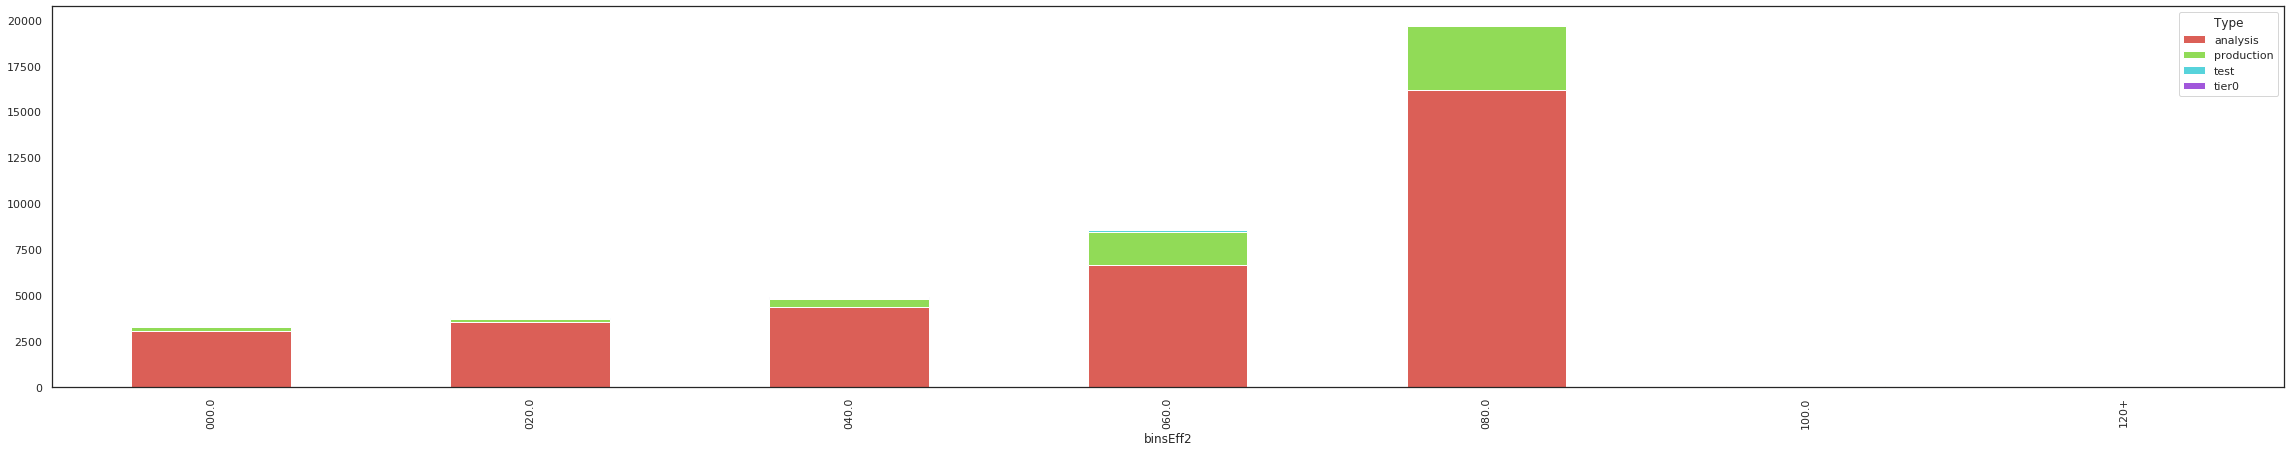

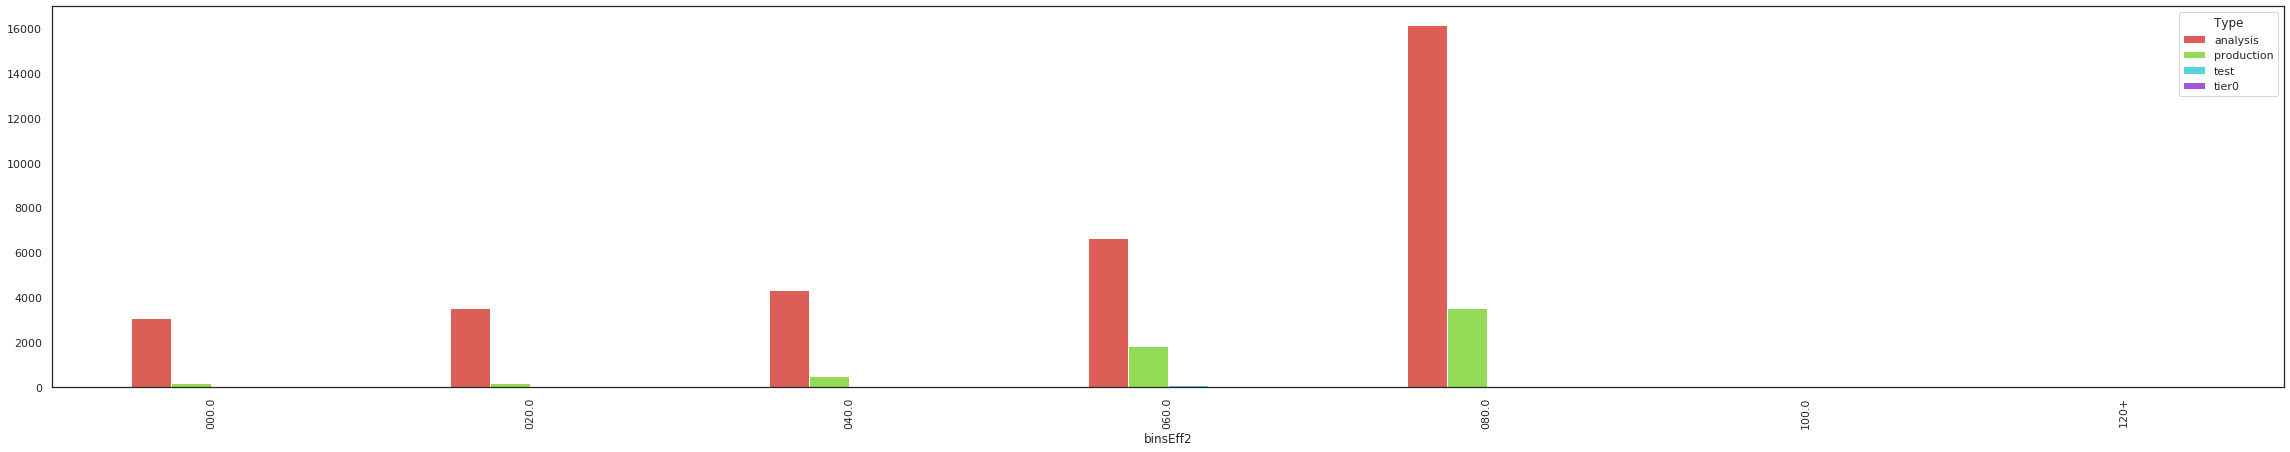

In [12]:
histo_eff2 = generate_histogram(pd_Eff2, "binsEff2", max_value=120)
histo_eff2_ns = generate_histogram(pd_Eff2, "binsEff2", max_value=120, stacked=False)

# List of workflows
Run the widgets cell once, then you can select the values and run the cells below the widgets to get results with the new parameters. 


In [13]:
cms_types = grouped_wf.select('Type').distinct().toPandas().Type.tolist()
range_slider = widgets.FloatRangeSlider(
    value=[0, 0.5],
    min=0,
    max=120,
    step=1/nbins_0_1,
    description='MemoryEff range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
type_selector = widgets.SelectMultiple(
    options=cms_types,
    value=(cms_types[0], ) if cms_types else (),
    description='Type:',
    disabled=False,
)
display(range_slider)
display(type_selector)

FloatRangeSlider(value=(0.0, 0.5), continuous_update=False, description='MemoryEff range:', max=120.0, step=20…

SelectMultiple(description='Type:', index=(0,), options=('production', 'analysis', 'test', 'tier0'), value=('p…

In [14]:
select_expr = f"""wf_cpueff BETWEEN {range_slider.value[0]} AND {range_slider.value[1]}
 AND Type in ({",".join([f"'{x}'" for x in type_selector.value])})
"""

In [15]:
print(select_expr)
selected_df = (
    grouped_wf.where(select_expr)
)


wf_cpueff BETWEEN 0.0 AND 0.5
 AND Type in ('production')



In [16]:
selected_pd = selected_df.toPandas()

In [17]:
selected_pd

,Workflow,Type,mean_cpueff,wf_cpueff,wf_cpus,wf_cputimehr,wf_wallclockhr
0,cmsunified_ACDC1_task_B2G-RunIISummer15wmLHEGS...,production,0.000000,0.000000,1.0,0.000000,0.006944
1,cmsunified_ACDC0_task_B2G-RunIIFall17wmLHEGS-0...,production,0.000000,0.000000,1.0,0.000000,0.010833
2,EXO-RunIISummer16NanoAODv6-06676,production,0.000000,0.000000,6.0,0.000000,0.170278
3,sagarwal_r-0-Run2018B-v1-MET-12Nov2019_UL2018_...,production,0.000000,0.000000,2.0,0.000000,0.019722
4,cmsunified_ACDC1_Run2017C-09Aug2019_UL2017-v1-...,production,0.000000,0.000000,1.0,0.000000,0.009722
5,pdmvserv_task_B2G-RunIISummer15wmLHEGS-02711__...,production,0.000000,0.000000,2.0,0.000000,0.009167
6,BPH-RunIIAutumn18NanoAODv6-00115,production,0.168919,0.178253,2.0,0.000278,0.155833
7,HIG-RunIISummer16NanoAODv5-03636,production,0.000000,0.000000,9.0,0.000000,0.075556
8,cmsunified_ACDC1_task_B2G-RunIISummer15wmLHEGS...,production,0.000000,0.000000,1.0,0.000000,0.008889
9,HIG-RunIIAutumn18NanoAODv5-02178,production,0.000000,0.000000,3.0,0.000000,0.019722


In [18]:
selected_pd.to_csv(f"workflows_cpueff{range_slider.value[0]}-{range_slider.value[1]}_{'-'.join(type_selector.value)}.csv.gz")